# Chest X-Ray Classification Project: Leveraging Deep Learning for Medical Image Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as pli
import seaborn as sns
import os
import tensorflow as tf
from PIL import Image
import torch
from torch import nn
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import pandas as pd
from sklearn.metrics import classification_report
from google.colab import drive
from torchvision import transforms
from torch.utils.data import ConcatDataset
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
import random
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
base_path = "/kaggle/input/data"
labels_file = os.path.join(base_path, "Data_Entry_2017.csv")

labels_df = pd.read_csv(labels_file)

image_folders = [f"images_{str(i).zfill(3)}" for i in range(1, 13)]

data_tot = []
for _, row in labels_df.iterrows():
    image_name = row["Image Index"]
    labels = row["Finding Labels"].split('|')

    image_path = None
    for folder in image_folders:
        potential_path = os.path.join(base_path, folder, "images", image_name)
        if os.path.exists(potential_path):
            image_path = potential_path
            break

    if image_path:
        data_tot.append({'image_path': image_path, 'labels': labels})

print(f"Total number of images found: {len(data_tot)}")
print(data_tot[:5])


Total number of images found: 112120
[{'image_path': '/kaggle/input/data/images_001/images/00000001_000.png', 'labels': ['Cardiomegaly']}, {'image_path': '/kaggle/input/data/images_001/images/00000001_001.png', 'labels': ['Cardiomegaly', 'Emphysema']}, {'image_path': '/kaggle/input/data/images_001/images/00000001_002.png', 'labels': ['Cardiomegaly', 'Effusion']}, {'image_path': '/kaggle/input/data/images_001/images/00000002_000.png', 'labels': ['No Finding']}, {'image_path': '/kaggle/input/data/images_001/images/00000003_000.png', 'labels': ['Hernia']}]


In [3]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
dtypes: float64(3), int64(5), object(4)
memory usage: 10.3+ MB


In [4]:
labels_df.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [5]:
labels_df.shape

(112120, 12)

In [6]:
labels_df['Finding Labels'].value_counts()

Finding Labels
No Finding                                                                      60361
Infiltration                                                                     9547
Atelectasis                                                                      4215
Effusion                                                                         3955
Nodule                                                                           2705
                                                                                ...  
Consolidation|Edema|Effusion|Mass|Nodule                                            1
Edema|Infiltration|Mass|Pneumonia|Pneumothorax                                      1
Consolidation|Effusion|Infiltration|Mass|Nodule|Pleural_Thickening|Pneumonia        1
Consolidation|Mass|Nodule|Pneumothorax                                              1
Cardiomegaly|Edema|Effusion|Fibrosis|Infiltration                                   1
Name: count, Length: 836, dtype: int64

In [7]:
num_class_1 = sum(["Infiltration" in r["labels"] for r in data_tot])
num_class_0 = sum(["Infiltration" not in r["labels"] for r in data_tot])

print(f"Class 1 (Infiltration): {num_class_1}")
print(f"Class 0 (Not Infiltration): {num_class_0}")

Class 1 (Infiltration): 19894
Class 0 (Not Infiltration): 92226


In [8]:
class_1_data = [r for r in data_tot if "Infiltration" in r["labels"]]
class_0_data = [r for r in data_tot if "Infiltration" not in r["labels"]]

random.seed(42)
class_1_sampled = random.sample(class_1_data, 6000)
class_0_sampled = random.sample(class_0_data, 8000)

balanced_data = class_0_sampled + class_1_sampled

new_num_class_1 = sum(["Infiltration" in r["labels"] for r in balanced_data])
new_num_class_0 = sum(["Infiltration" not in r["labels"] for r in balanced_data])

print(f"New Class 1 (Infiltration): {new_num_class_1}")
print(f"New Class 0 (Not Infiltration): {new_num_class_0}")

New Class 1 (Infiltration): 6000
New Class 0 (Not Infiltration): 8000


In [9]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)  # For multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [10]:
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

**MobileNetV1** introduced **Depthwise Separable Convolutions**, splitting standard convolutions into two steps: a **depthwise convolution** (applying filters per channel) and a **pointwise convolution** (1x1 to combine channels). This drastically reduced computational cost and parameters compared to traditional CNNs, making the model efficient for mobile devices.

**MobileNetV2** improved upon MobileNetV1 with **inverted residuals** and **linear bottlenecks**. Inverted residuals connect bottlenecks (with fewer channels) via shortcuts, reducing computation, while linear bottlenecks avoid non-linear activations in compressed layers to preserve critical information. These innovations increased efficiency and accuracy, further optimizing MobileNetV2 for resource-constrained environments.

### **Formulas for Precision, Recall, and F1-Score**

1. **Precision**: Measures the proportion of correctly predicted positive instances among all predicted positives.

$
\text{Precision} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Positives (FP)}}
$

---

2. **Recall (Sensitivity or True Positive Rate)**: Measures the proportion of correctly predicted positive instances among all actual positives.

$
\text{Recall} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Negatives (FN)}}
$

---

3. **F1-Score**: The harmonic mean of precision and recall, used to balance both metrics when there is class imbalance.

$
\text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$

---

### Explanation of Variables:
- **True Positives (TP)**: Instances correctly classified as positive.
- **False Positives (FP)**: Instances incorrectly classified as positive.
- **False Negatives (FN)**: Instances incorrectly classified as negative.

# TensorFlow Keras / MobileNetV2

In [11]:
def preprocess_item(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [224, 224]) / 255.0
    return image, label

paths = [item['image_path'] for item in balanced_data]
labels = [1 if "Infiltration" in item["labels"] else 0 for item in balanced_data]

dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
# Maps the preprocess_item function over the dataset with parallel processing to improve speed
# (num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.map(lambda x, y: preprocess_item(x, y), num_parallel_calls=tf.data.AUTOTUNE)

In [12]:
# Shuffle to improve your workout
dataset = dataset.shuffle(buffer_size=len(balanced_data))
dataset_nobatch = dataset
# Batch creation. Prefetch to load next batch in parallel
dataset = dataset.batch(64).prefetch(tf.data.AUTOTUNE)

In [13]:
for images, labels in dataset.take(1):
    print(f"Batch shape: {images.shape}, Labels shape: {labels.shape}")

Batch shape: (64, 224, 224, 3), Labels shape: (64,)


In [14]:
total_images = 0
for images, labels in dataset:
   total_images += images.shape[0]

print(f"Total_number_of: {total_images}")

Total_number_of: 14000


**Model Description - Fine Tuning**    
A binary classification model is defined using MobileNetV2 as the base, pretrained on ImageNet. The base model is used as a feature extractor with its weights frozen (trainable=False).

Key components include:  
- GlobalAveragePooling2D.   
- A fully connected layer with 64 units and ReLU activation.
- An output layer with 1 unit and sigmoid activation for binary classification.  
- Optimizer: Adam, configured with a learning rate of 0.001.
- Loss function: Binary crossentropy, suitable for binary classification tasks.
- Metric: Accuracy, to evaluate the model’s performance.

In [15]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
# the pre-trained model uses weights derived from training on ImageNet
base_model.trainable = False

model_tf = tf.keras.Sequential([base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
model_tf.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])

In [17]:
dataset = dataset.shuffle(buffer_size=len(balanced_data))
dataset_size = len(dataset)

test_size = int(dataset_size * 0.2)
train_size = dataset_size - test_size

test_set = dataset.take(test_size)  # Top 20% for the test
train_set = dataset.skip(test_size)  # Remaining 80% for training

In [18]:
print(f"Dataset (batch): {dataset_size}")
print(f"Test set (batch): {test_size}")
print(f"Training set (batch): {train_size}")

Dataset (batch): 219
Test set (batch): 43
Training set (batch): 176


In [19]:
history = model_tf.fit(train_set, epochs=4)

Epoch 1/4
176/176 ━━━━━━━━━━━━━━━━━━━━ 102s 85ms/step - accuracy: 0.6074 - loss: 0.6763
Epoch 2/4
176/176 ━━━━━━━━━━━━━━━━━━━━ 84s 55ms/step - accuracy: 0.6365 - loss: 0.6391
Epoch 3/4
176/176 ━━━━━━━━━━━━━━━━━━━━ 84s 56ms/step - accuracy: 0.6556 - loss: 0.6299
Epoch 4/4
176/176 ━━━━━━━━━━━━━━━━━━━━ 84s 57ms/step - accuracy: 0.6468 - loss: 0.6358


In [20]:
test_loss, test_accuracy = model_tf.evaluate(test_set)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

43/43 ━━━━━━━━━━━━━━━━━━━━ 80s 57ms/step - accuracy: 0.6748 - loss: 0.6134
Test Loss: 0.6101019978523254, Test Accuracy: 0.6809592843055725


In [21]:
y_true = []
y_pred = []
for images, labels in test_set:
    preds = model_tf.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype(int).flatten())

print(classification_report(y_true, y_pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━

**Class 0 (Not Infiltration)**:
   - **Precision**: 65% → Moderate ability to avoid false positives.
   - **Recall**: 86% → Excellent ability to identify negatives correctly.

**Class 1 (Infiltration)**:
   - **Precision**: 70% → Good ability to avoid false positives.
   - **Recall**: 41% → Low ability to capture positives (many false negatives).

**Accuracy**:  
   - 66% → Indicates acceptable general performance with room for improvement.


# Pytorch / MobileNetV2



In [22]:
class ChestXRayDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data[idx]['image_path']
        label = 1 if "Infiltration" in self.data[idx]['labels'] else 0
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

In [23]:
# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()])

dataset_pytorch = ChestXRayDataset(balanced_data, transform=transform)
train_size = int(0.8 * len(dataset_pytorch))
test_size = len(dataset_pytorch) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset_pytorch, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

**Model Description - Fine Tuning**  
A binary classification model is defined using MobileNetV2 as the base, pretrained on ImageNet. The base model is used as a feature extractor with its weights retained from the pretraining.

Key components include:
  
- A linear classifier, replacing the original output layer, with a single output logit for binary classification.
- Loss function: BCEWithLogitsLoss, which combines sigmoid activation and binary crossentropy for stable handling of logits.
- Optimizer: Adam, configured with a learning rate of 0.001.

In [24]:
# Pre-trained model
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.last_channel, 1)  # Binary output
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 124MB/s]


In [25]:
# Training
num_epochs = 4

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float()
        optimizer.zero_grad()
        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1/4, Loss: 0.6517
Epoch 2/4, Loss: 0.6311
Epoch 3/4, Loss: 0.6210
Epoch 4/4, Loss: 0.6119


In [26]:
# Validation
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).squeeze()
        preds = (torch.sigmoid(outputs) > 0.5).int()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("Test Classification Report:")
print(classification_report(y_true, y_pred))

Test Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.80      0.73      1590
           1       0.64      0.47      0.54      1210

    accuracy                           0.66      2800
   macro avg       0.65      0.64      0.63      2800
weighted avg       0.66      0.66      0.65      2800



**Class 0 (Not Infiltration)**:
- **Precision**: 66% → Moderate ability to avoid false positives.
- **Recall**: 80% → Strong ability to correctly identify negatives.

**Class 1 (Infiltration)**:
- **Precision**: 64% → Moderate ability to avoid false positives.
- **Recall**: 47% → Low ability to capture positives, with many false negatives.

**Accuracy**:
- 66% → Indicates acceptable overall performance, but with room for improvement in minority class detection.

# Data Augmentation and Balancing for Class 1  
This section implements data augmentation techniques to balance the dataset and improve the model's ability to detect positive cases (Class 1 - "Infiltration"). Augmentation is applied selectively to Class 1 images, and the augmented data is combined with the original dataset for training.

## TensorFlow Keras / MobileNetV2 (with Data Augmentation)

In [27]:
class_1_sampled_to_augment = random.sample(class_1_sampled, 2000)
print(len(class_1_sampled_to_augment))

2000


In [28]:
def augment_image(image):
    # Augmentation operations
    image = tf.image.random_flip_left_right(image)  # Horizontal Flip
    image = tf.image.random_flip_up_down(image)    # Vertical Flip
    image = tf.image.rot90(image, k=np.random.randint(1, 4))  # Random rotation
    return image

# Preprocessing and augmentation function
def preprocess_and_augment(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [224, 224]) / 255.0
    image = augment_image(image)
    return image, label

class_1_paths_to_augment = [item['image_path'] for item in class_1_sampled_to_augment]
class_1_labels_to_augment = [1] * len(class_1_paths_to_augment)
class_1_sampled_to_augment = tf.data.Dataset.from_tensor_slices((class_1_paths_to_augment, class_1_labels_to_augment))

class_1_sampled_augmented = class_1_sampled_to_augment.map(preprocess_and_augment, num_parallel_calls=tf.data.AUTOTUNE)

In [29]:
augmented_count = sum(1 for _ in class_1_sampled_augmented)
print(f"Number of augmented samples: {augmented_count}")

Number of augmented samples: 2000


In [30]:
final_dataset = dataset_nobatch.concatenate(class_1_sampled_augmented)
print(len(final_dataset))

16000


In [31]:
# Apply shuffle and batching to the combined dataset
final_dataset = final_dataset.shuffle(buffer_size=len(final_dataset))
final_dataset = final_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

In [32]:
dataset_size = len(final_dataset)
test_size = int(dataset_size * 0.2)
train_size = dataset_size - test_size

test_set = final_dataset.take(test_size)  # Top 20% for the test
train_set = final_dataset.skip(test_size)  # Remaining 80% for training

In [33]:
print(f"Dataset totale: {dataset_size}")
print(f"Test set: {test_size}")
print(f"Training set: {train_size}")

Dataset totale: 250
Test set: 50
Training set: 200


In [34]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_tf.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [35]:
history = model_tf.fit(train_set, epochs=4, validation_data = test_set)

Epoch 1/4
200/200 ━━━━━━━━━━━━━━━━━━━━ 186s 496ms/step - accuracy: 0.6831 - loss: 0.5752 - val_accuracy: 0.7094 - val_loss: 0.5409
Epoch 2/4
200/200 ━━━━━━━━━━━━━━━━━━━━ 178s 485ms/step - accuracy: 0.6968 - loss: 0.5469 - val_accuracy: 0.7128 - val_loss: 0.5353
Epoch 3/4
200/200 ━━━━━━━━━━━━━━━━━━━━ 180s 488ms/step - accuracy: 0.7091 - loss: 0.5384 - val_accuracy: 0.7044 - val_loss: 0.5349
Epoch 4/4
200/200 ━━━━━━━━━━━━━━━━━━━━ 178s 485ms/step - accuracy: 0.7109 - loss: 0.5377 - val_accuracy: 0.7169 - val_loss: 0.5254


In [36]:
test_loss, test_accuracy = model_tf.evaluate(test_set)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 83s 62ms/step - accuracy: 0.7068 - loss: 0.5358
Test Loss: 0.5232852697372437, Test Accuracy: 0.71875


In [37]:
y_true = []
y_pred = []

for images, labels in test_set:
    preds = model_tf.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(preds.flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

thresholds = [0.4, 0.5]
for threshold in thresholds:
    y_pred_class = (y_pred > threshold).astype(int)
    print(f"Classification report for threshold = {threshold}")
    print(classification_report(y_true, y_pred_class))


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━

**Class 0 (Not Infiltration)**:  
- **Precision**: 67% → Moderate ability to avoid false positives.  
- **Recall**: 86% → Strong ability to correctly identify negatives.  

**Class 1 (Infiltration)**:  
- **Precision**: 80% → High ability to avoid false positives.  
- **Recall**: 58% → Moderate ability to capture positives, with some false negatives.  

**Accuracy**:  
- 72% → Indicates good overall performance, but with some room for improvement in detecting positives.  

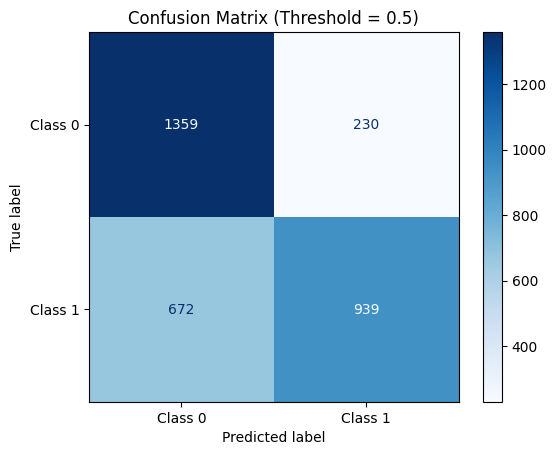

In [38]:
threshold = 0.5
y_pred_class = (y_pred > threshold).astype(int)
cm = confusion_matrix(y_true, y_pred_class)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap='Blues', values_format='d')
plt.title(f'Confusion Matrix (Threshold = {threshold})')
plt.show()

**Model Description - Fine Tuning**     
A binary classification model is defined using MobileNetV2 as the base, pretrained on ImageNet. The base model is used as a feature extractor with its weights frozen (trainable=False).

Key components include:  
- GlobalMaxPooling2D.   
- A fully connected layer with 64 units and ReLU activation.
- An output layer with 1 unit and sigmoid activation for binary classification.  
- Optimizer: Adam, configured with a learning rate of 0.001.
- Loss function: Binary crossentropy, suitable for binary classification tasks.
- Metric: Accuracy, to evaluate the model’s performance.

In [39]:
model_tf_max = tf.keras.Sequential([base_model,
    tf.keras.layers.GlobalMaxPooling2D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')])

In [40]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_tf_max.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [41]:
history = model_tf_max.fit(train_set, epochs=5,validation_data=test_set)

test_loss, test_accuracy = model_tf_max.evaluate(test_set)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Epoch 1/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 187s 495ms/step - accuracy: 0.6000 - loss: 1.1732 - val_accuracy: 0.6781 - val_loss: 0.5622
Epoch 2/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 192s 554ms/step - accuracy: 0.6711 - loss: 0.5731 - val_accuracy: 0.6894 - val_loss: 0.5529
Epoch 3/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 183s 482ms/step - accuracy: 0.6716 - loss: 0.5718 - val_accuracy: 0.6834 - val_loss: 0.5578
Epoch 4/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 183s 502ms/step - accuracy: 0.6802 - loss: 0.5643 - val_accuracy: 0.6947 - val_loss: 0.5501
Epoch 5/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 195s 513ms/step - accuracy: 0.6890 - loss: 0.5557 - val_accuracy: 0.6891 - val_loss: 0.5567
50/50 ━━━━━━━━━━━━━━━━━━━━ 98s 62ms/step - accuracy: 0.6862 - loss: 0.5549
Test Loss: 0.5608054995536804, Test Accuracy: 0.6837499737739563


In [42]:
y_true = []
y_pred = []

for images, labels in test_set:
    preds = model_tf_max.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(preds.flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

thresholds = [0.4, 0.5]
for threshold in thresholds:
    y_pred_class = (y_pred > threshold).astype(int)
    print(f"Classification report for threshold = {threshold}")
    print(classification_report(y_true, y_pred_class))

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━

**Class 0 (Not Infiltration)**:  
- **Precision**: 65% → Moderate ability to avoid false positives.  
- **Recall**: 81% → Strong ability to correctly identify negatives.  

**Class 1 (Infiltration)**:  
- **Precision**: 75% → Good ability to avoid false positives.  
- **Recall**: 58% → Moderate ability to capture positives, with some false negatives.  

**Accuracy**:  
- 69% → Indicates solid overall performance, but improvements are needed in positive case detection.  

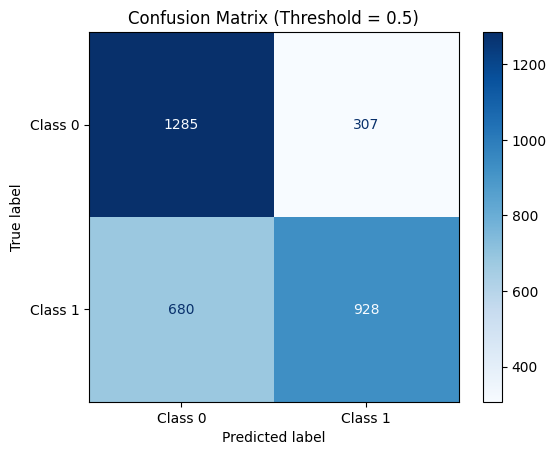

In [43]:
threshold = 0.5
y_pred_class = (y_pred > threshold).astype(int)
cm = confusion_matrix(y_true, y_pred_class)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap='Blues', values_format='d')
plt.title(f'Confusion Matrix (Threshold = {threshold})')
plt.show()

## Pytorch / MobileNetV2 (with Data Augmentation)


In [44]:
# Transformations with Data Augmentation
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Horizontal Flip
    transforms.RandomVerticalFlip(p=0.5),    # Vertical Flip
    transforms.RandomRotation(degrees=90),   # Random rotation within 45°
    transforms.Resize((224, 224)),
    transforms.ToTensor()])

# Basic transformations (without augmentation)
base_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()])

# Original dataset with basic transformations
base_dataset = ChestXRayDataset(balanced_data, transform=base_transforms)

In [45]:
# Dataset augmented for class 1 only
class_1_sampled_to_augment = random.sample(class_1_sampled, 2000)
class_1_data_augmented = ChestXRayDataset(class_1_sampled_to_augment, transform=augmentation_transforms)
print(len(class_1_data_augmented))

# Combine the original and augmented dataset
combined_dataset = ConcatDataset([base_dataset, class_1_data_augmented])
print(len(combined_dataset))

2000
16000


In [46]:
# DataLoader
train_size = int(0.8 * len(combined_dataset))
test_size = len(combined_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(combined_dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 123MB/s]



--- Training with Learning Rate: 0.001 ---
Epoch 1/5, Training Loss: 0.6298, Test Loss: 0.5999
Epoch 2/5, Training Loss: 0.6061, Test Loss: 0.5947
Epoch 3/5, Training Loss: 0.5968, Test Loss: 0.5927
Epoch 4/5, Training Loss: 0.5912, Test Loss: 0.5939
Epoch 5/5, Training Loss: 0.5891, Test Loss: 0.5919
Classification report for threshold = 0.4
              precision    recall  f1-score   support

           0       0.68      0.55      0.61      1599
           1       0.62      0.74      0.68      1601

    accuracy                           0.65      3200
   macro avg       0.65      0.65      0.64      3200
weighted avg       0.65      0.65      0.64      3200

Classification report for threshold = 0.5
              precision    recall  f1-score   support

           0       0.64      0.76      0.69      1599
           1       0.70      0.58      0.63      1601

    accuracy                           0.67      3200
   macro avg       0.67      0.67      0.66      3200
weighted avg 

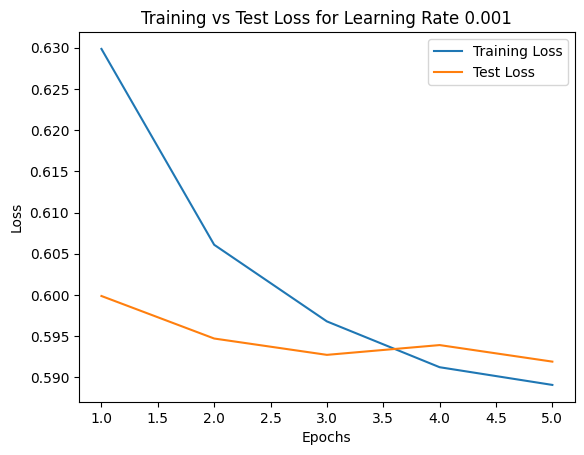


--- Training with Learning Rate: 0.0001 ---
Epoch 1/5, Training Loss: 0.6720, Test Loss: 0.6533
Epoch 2/5, Training Loss: 0.6474, Test Loss: 0.6342
Epoch 3/5, Training Loss: 0.6340, Test Loss: 0.6247
Epoch 4/5, Training Loss: 0.6243, Test Loss: 0.6186
Epoch 5/5, Training Loss: 0.6199, Test Loss: 0.6134
Classification report for threshold = 0.4
              precision    recall  f1-score   support

           0       0.69      0.42      0.52      1599
           1       0.58      0.81      0.68      1601

    accuracy                           0.61      3200
   macro avg       0.64      0.61      0.60      3200
weighted avg       0.64      0.61      0.60      3200

Classification report for threshold = 0.5
              precision    recall  f1-score   support

           0       0.65      0.71      0.68      1599
           1       0.68      0.61      0.65      1601

    accuracy                           0.66      3200
   macro avg       0.66      0.66      0.66      3200
weighted avg

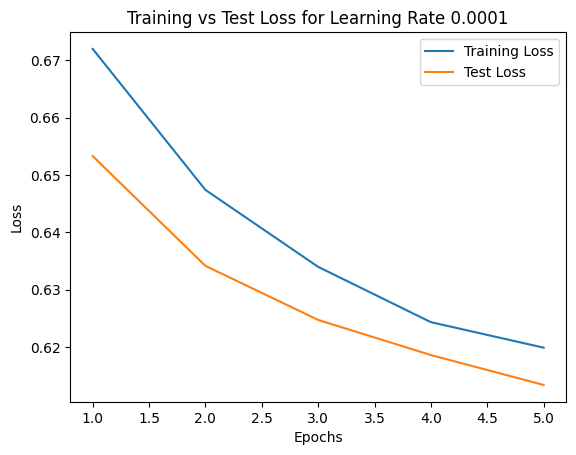

In [47]:
# Define a function to calculate test loss
def evaluate_model_loss(model, criterion, data_loader, device):
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device).float()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            test_loss += loss.item()
    return test_loss / len(data_loader)

# Update train_and_evaluate function
def train_and_evaluate(model, optimizer, learning_rate, num_epochs, train_loader, test_loader, thresholds=[0.4, 0.5]):
    print(f"\n--- Training with Learning Rate: {learning_rate} ---")
    training_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float()
            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Calculate average training loss
        training_loss = running_loss / len(train_loader)
        training_losses.append(training_loss)

        # Calculate test loss
        test_loss = evaluate_model_loss(model, criterion, test_loader, device)
        test_losses.append(test_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {training_loss:.4f}, Test Loss: {test_loss:.4f}")

    # Evaluation
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).squeeze()
            probs = torch.sigmoid(outputs)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(probs.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Metrics for each threshold
    for threshold in thresholds:
        y_pred_class = (y_pred > threshold).astype(int)
        print(f"Classification report for threshold = {threshold}")
        print(classification_report(y_true, y_pred_class))

    # Return metrics and losses for analysis
    return y_true, y_pred, training_losses, test_losses

# Initialize models, optimizers, and train
results = {}
learning_rates = [0.001, 0.0001]

for lr in learning_rates:
    # Clone the base model
    model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
    model.classifier[1] = nn.Linear(model.last_channel, 1)
    model = model.to(device)

    # Define optimizer
    optimizer = optim.Adam(model.classifier.parameters(), lr=lr)

    # Train and evaluate
    y_true, y_pred, training_losses, test_losses = train_and_evaluate(model, optimizer, lr, num_epochs=5, train_loader=train_loader, test_loader=test_loader)

    # Store results for further analysis
    results[lr] = (y_true, y_pred, training_losses, test_losses)

    # Plot Training vs Test Loss for this learning rate
    plt.figure()
    plt.plot(range(1, len(training_losses) + 1), training_losses, label="Training Loss")
    plt.plot(range(1, len(test_losses) + 1), test_losses, label="Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Training vs Test Loss for Learning Rate {lr}")
    plt.legend()
    plt.show()

**Class 0 (Not Infiltration)**:  
- **Precision**: 64% → Moderate ability to avoid false positives.  
- **Recall**: 76% → Good ability to correctly identify negatives.  

**Class 1 (Infiltration)**:  
- **Precision**: 70% → Good ability to avoid false positives.  
- **Recall**: 58% → Moderate ability to capture positives, with some false negatives.  

**Accuracy**:  
- 67% → Indicates acceptable overall performance, with room for improvement in both classes.  

In [48]:
y_true, y_pred = results[0.001][:2]
print(y_true, y_pred)

[1 1 1 ... 0 1 0] [0.21955071 0.9595804  0.35407686 ... 0.48484266 0.96058786 0.64720243]


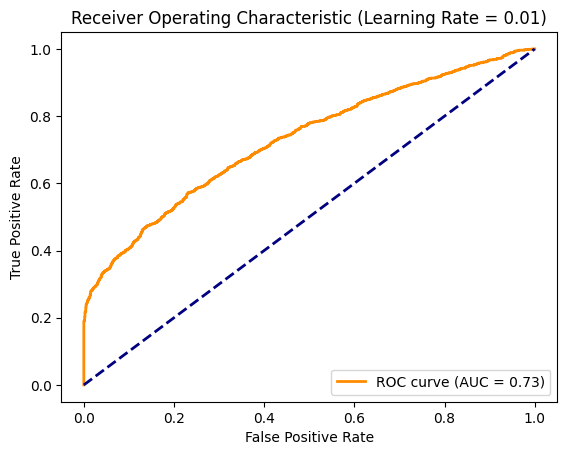

In [49]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Learning Rate = 0.01)')
plt.legend(loc='lower right')
plt.show()

In [ ]:
for i, (thr, fp, tp) in enumerate(zip(thresholds_roc, fpr, tpr)):
    if i % 25 == 0:  # Print key thresholds
        print(f"Threshold: {thr:.2f}, FPR: {fp:.2f}, TPR: {tp:.2f}")

Threshold: 1.99, FPR: 0.00, TPR: 0.00
Threshold: 0.75, FPR: 0.01, TPR: 0.25
Threshold: 0.71, FPR: 0.02, TPR: 0.29
Threshold: 0.68, FPR: 0.03, TPR: 0.31
Threshold: 0.66, FPR: 0.04, TPR: 0.33
Threshold: 0.65, FPR: 0.05, TPR: 0.34
Threshold: 0.63, FPR: 0.07, TPR: 0.37
Threshold: 0.62, FPR: 0.08, TPR: 0.39
Threshold: 0.61, FPR: 0.09, TPR: 0.40
Threshold: 0.60, FPR: 0.11, TPR: 0.42
Threshold: 0.58, FPR: 0.12, TPR: 0.44
Threshold: 0.57, FPR: 0.13, TPR: 0.46
Threshold: 0.56, FPR: 0.15, TPR: 0.48
Threshold: 0.55, FPR: 0.17, TPR: 0.49
Threshold: 0.54, FPR: 0.18, TPR: 0.51
Threshold: 0.53, FPR: 0.20, TPR: 0.52
Threshold: 0.52, FPR: 0.21, TPR: 0.54
Threshold: 0.51, FPR: 0.23, TPR: 0.56
Threshold: 0.50, FPR: 0.24, TPR: 0.58
Threshold: 0.49, FPR: 0.26, TPR: 0.59
Threshold: 0.48, FPR: 0.28, TPR: 0.60
Threshold: 0.47, FPR: 0.29, TPR: 0.62
Threshold: 0.47, FPR: 0.31, TPR: 0.63
Threshold: 0.46, FPR: 0.32, TPR: 0.65
Threshold: 0.45, FPR: 0.34, TPR: 0.66
Threshold: 0.44, FPR: 0.36, TPR: 0.67
Threshold: 0

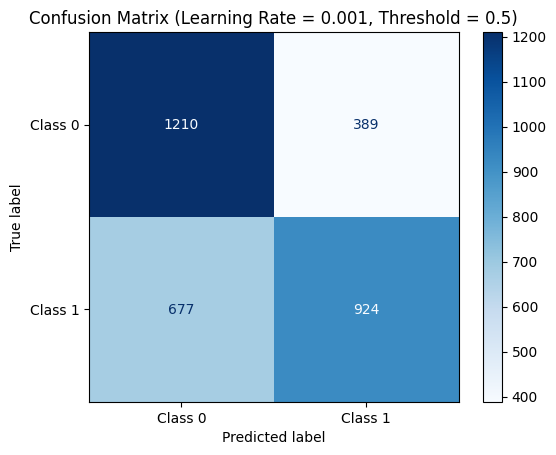

In [51]:
# Confusion Matrix for threshold = 0.5
threshold = 0.5
y_pred_class = (y_pred > threshold).astype(int)
cm = confusion_matrix(y_true, y_pred_class)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix (Learning Rate = 0.001, Threshold = 0.5)')
plt.show()